# How much average monthly income I could expect from my investments in terms of lease/rent after upgrading properties, paying mortgage, and paying taxes. Calculate my ~ROI.

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import us
import seaborn as sns

# TODO: turn errors off

## Assumptions

- Apply an average upgrade cost to all properties (2%-6%, assume 4%) [Google](https://www.google.com/search?sca_esv=f9439907e5543505&rlz=1C5CHFA_enUS1066US1066&sxsrf=ADLYWIKGALe9lErWdMYpzzi_ACDXvpSxuQ:1733020033405&q=So+if+I+buy+a+house,+what+is+the+average+cost+to+spruce+up+the+house+(i.+paint,+carpet,+etc)?+Is+there+a+percentage+I+can+apply+to+the+home+value+to+get+this+value?&spell=1&sa=X&ved=2ahUKEwjY-OrbwoWKAxVarYkEHXoMMNsQBSgAegQIDRAB&biw=2560&bih=1318&dpr=1)
- Mortage rate: 6.31% **Source:** [Bankrate](https://www.bankrate.com/mortgages/mortgage-rates/)
- 30 year fixed mortgage, 20% down payment
- Property tax rates by state imported as property_tax_rates.csv **Source:** [Maptive](https://www.maptive.com/interactive-maps/property-taxes-by-state/)
- Renters pay all utilities
- Rent rates: Imported as rent_rates.csv **Source:** [Rentdata](https://www.rentdata.org/states/2024)

## Rent analysis for 1-4 bedroom properties (Single Family and Condo included)
- We are not analyzing 5+ bedroom data from Zillow since we can't determine the rent per bedroom since all properties with 5+ bedrooms are included.

### Data Loading

In [164]:
# File paths
tax_rates_file_path = 'property_tax_rates.csv'
rent_rates_file_path = 'rent_rates.csv'
price_data_1br_path = 'Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
price_data_2br_path = 'Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
price_data_3br_path = 'Zip_zhvi_bdrmcnt_3_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
price_data_4br_path = 'Zip_zhvi_bdrmcnt_4_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'

# Load the CSV files into pandas DataFrames
tax_rates = pd.read_csv(tax_rates_file_path)
rent_rates = pd.read_csv(rent_rates_file_path)
price_data_1br = pd.read_csv(price_data_1br_path)
price_data_2br = pd.read_csv(price_data_2br_path)
price_data_3br = pd.read_csv(price_data_3br_path)
price_data_4br = pd.read_csv(price_data_4br_path)

### Data Cleaning

In [165]:
# We tried filtering the data by IQR however the bad houses were still present
# We only want to focus on data within the first and third quartiles to ensure
# houses are up to our standards
# Function to filter dataset to keep values only within Q1 and Q3
def filter_outliers_q1_q3(data, min_price):
    state_column = 'State'
    price_column_pattern = r'\d{4}-\d{2}-\d{2}'

    # Identify columns containing price data based on the pattern
    date_columns = data.columns[data.columns.str.contains(price_column_pattern)]

    # Initialize a filtered DataFrame
    filtered_data = data.copy()

    # Group by state and filter for each date column
    for date_column in date_columns:
        # Group by state and calculate Q1 and Q3
        grouped = data.groupby(state_column)[date_column]
        q1 = grouped.transform('quantile', 0.25)
        q3 = grouped.transform('quantile', 0.75)

        # Filter values within Q1 and Q3
        filtered_data[date_column] = data[date_column].where(
            (data[date_column] >= q1) & (data[date_column] <= q3) & (data[date_column] >= min_price)
        )

    return filtered_data

# Justify why we chose these min prices
price_data_1br = filter_outliers_q1_q3(price_data_1br, 100000)
display(price_data_1br.head())

price_data_2br = filter_outliers_q1_q3(price_data_2br, 125000)
display(price_data_2br.head())

price_data_3br = filter_outliers_q1_q3(price_data_3br, 175000)
display(price_data_3br.head())

price_data_4br = filter_outliers_q1_q3(price_data_4br, 200000)
display(price_data_4br.head())

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,306037.477113,305616.305965,307888.682652,310136.389106,312741.797348,313122.313537,312959.892553,312715.572975,313046.769057,313472.492906
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,112072.706620,111236.200845,110354.181709,109427.109513,108873.046807,108548.491316,108549.511993,108283.753748,107797.195799,107247.859298
3,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,536868.926083,534792.886208,535734.313917,535564.063409,537622.424270,535178.852051,534821.312676,534628.351058,540448.238666,546253.341507
4,95992,10,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,NaN,...,466813.997167,460540.118248,453929.388729,450329.707775,449752.085367,448533.745228,449324.145706,451417.346765,456933.455058,461139.428051


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,197156.658881,198046.036836,199047.023359,199759.487578,200290.914634,200226.655699,200042.184169,199759.188887,199320.474367,198611.095705
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,184936.259264,185034.143138,185382.012107,185745.417750,186078.452889,185828.482631,185383.731983,184713.716036,183959.319741,183035.644481


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,NaN,...,597110.282864,600013.290525,605530.326633,614369.310957,621854.036064,627498.779072,632559.102771,638344.558128,644929.021835,650898.673866
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,258649.155022,259405.387571,260506.184251,261397.527129,261973.568765,262044.494143,261985.854654,261857.787424,261681.142666,261229.557649
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,250494.075429,251074.393225,252063.289038,252894.845939,253362.606070,253177.696003,252896.460701,252521.535318,252172.905563,251545.145865


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,NaN,...,730572.948488,733809.139590,740792.313674,752672.110814,762382.175304,769853.194537,775789.953090,781992.333205,789647.735754,797695.365930
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,297761.822924,298373.372830,299465.470567,300553.466956,301156.784454,301083.344026,300731.246630,300490.008390,300266.840207,299883.577174
3,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,304630.633394,305036.044722,306064.123832,307292.403406,307928.786064,307778.646643,307409.499209,307205.535009,307051.316769,306632.987612
4,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# Since we're analyze the most recent house price data (October 2024), we can ignore all other months if they are blank.
# However we should remove rows where October 2024 data is missing from all price data

# Using 10/31/24 as the column key was giving an error
oct_2024_column = '2024-10-31'

# Keep rows with October 2024 data in the cell since we're only analyzing that month
price_data_1br = price_data_1br[price_data_1br[oct_2024_column].notna()]
price_data_2br = price_data_2br[price_data_2br[oct_2024_column].notna()]
price_data_3br = price_data_3br[price_data_3br[oct_2024_column].notna()]
price_data_4br = price_data_4br[price_data_4br[oct_2024_column].notna()]

# Define default tax rate for DC (1.1%)
default_tax_rate = '1.1%'  # Use string format to match existing data format

# Add a row for DC with default tax rates for all years
new_row = {
    'State': 'District of Columbia',
    '2020': default_tax_rate,
    '2021': default_tax_rate,
    '2022': default_tax_rate,
    '2023': default_tax_rate,
    '2024': default_tax_rate
}

# Append the new row to the DataFrame
tax_rates = pd.concat([tax_rates, pd.DataFrame([new_row])], ignore_index=True)

# Function to safely map state names to abbreviations
def safe_state_lookup(state_name):
    state_name = state_name.strip()  # Strip any extra spaces
    if state_name == "District of Columbia":
        return "DC"  # Special handling for DC
    state = us.states.lookup(state_name)
    return state.abbr if state else state_name  # Return abbreviation if found, otherwise return original name

# State names in the property_tax_rates and rent_rates
# need to be converted into a abbreviations to easily join data from the Zillow data set
# Use the us Python library to do this easily
tax_rates['State'] = tax_rates['State'].apply(safe_state_lookup)
rent_rates['State'] = rent_rates['State'].apply(safe_state_lookup)

# Function to convert strings to float
# The tax rates data set is type string, which needs to be converted to float
def convert_to_float(value):
    return float(value.strip('%')) / 100 if isinstance(value, str) and '%' in value else value

# Apply conversion to all columns except 'State'
for column in tax_rates.columns[1:]:  # Skip 'State'
    tax_rates[column] = tax_rates[column].apply(convert_to_float)

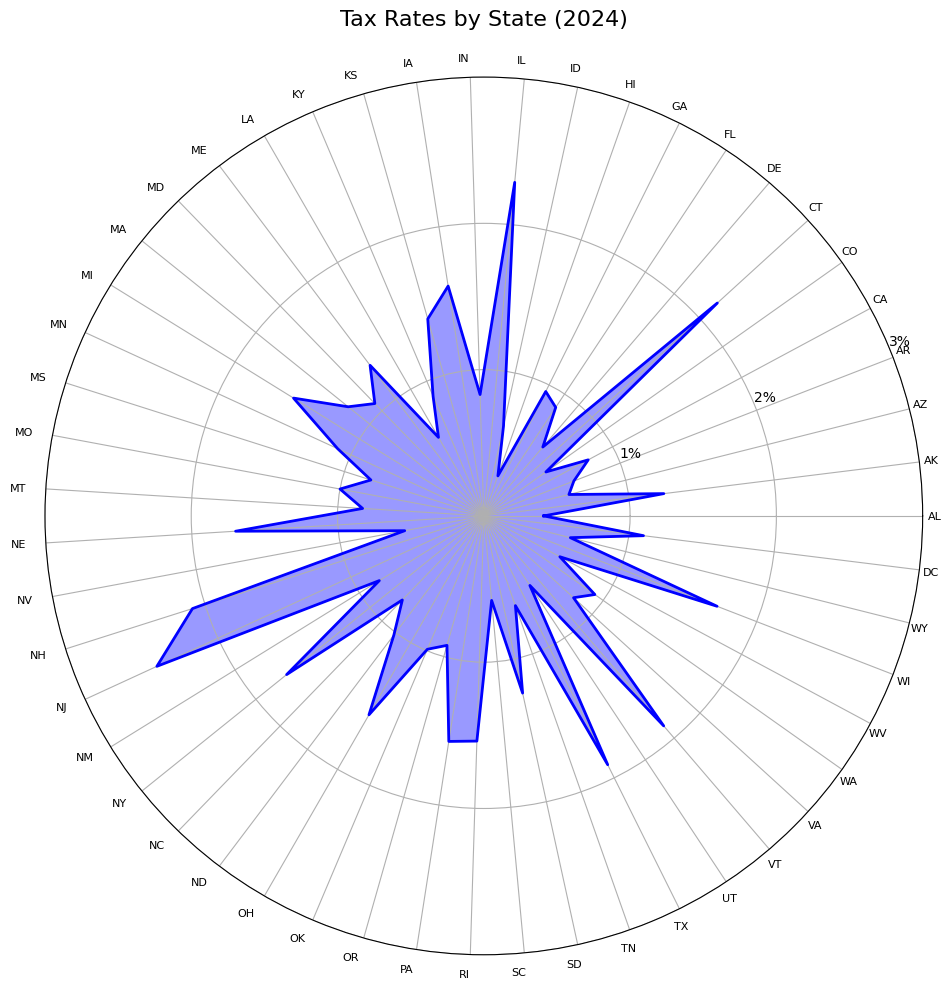

In [167]:
# Radar Plot of tax rates

states = tax_rates['State']
values = tax_rates['2024']
num_states = len(states)

# Calculate angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False).tolist()
values = np.append(values, values[0])
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='b', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='blue', alpha=0.4)

# Add labels
ax.set_yticks([0.01, 0.02, 0.03])
ax.set_yticklabels(["1%", "2%", "3%"], color="black", size=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(states, size=8, ha='right')

# Title and layout adjustments
plt.title('Tax Rates by State (2024)', size=16, pad=20)
plt.tight_layout()
plt.show()

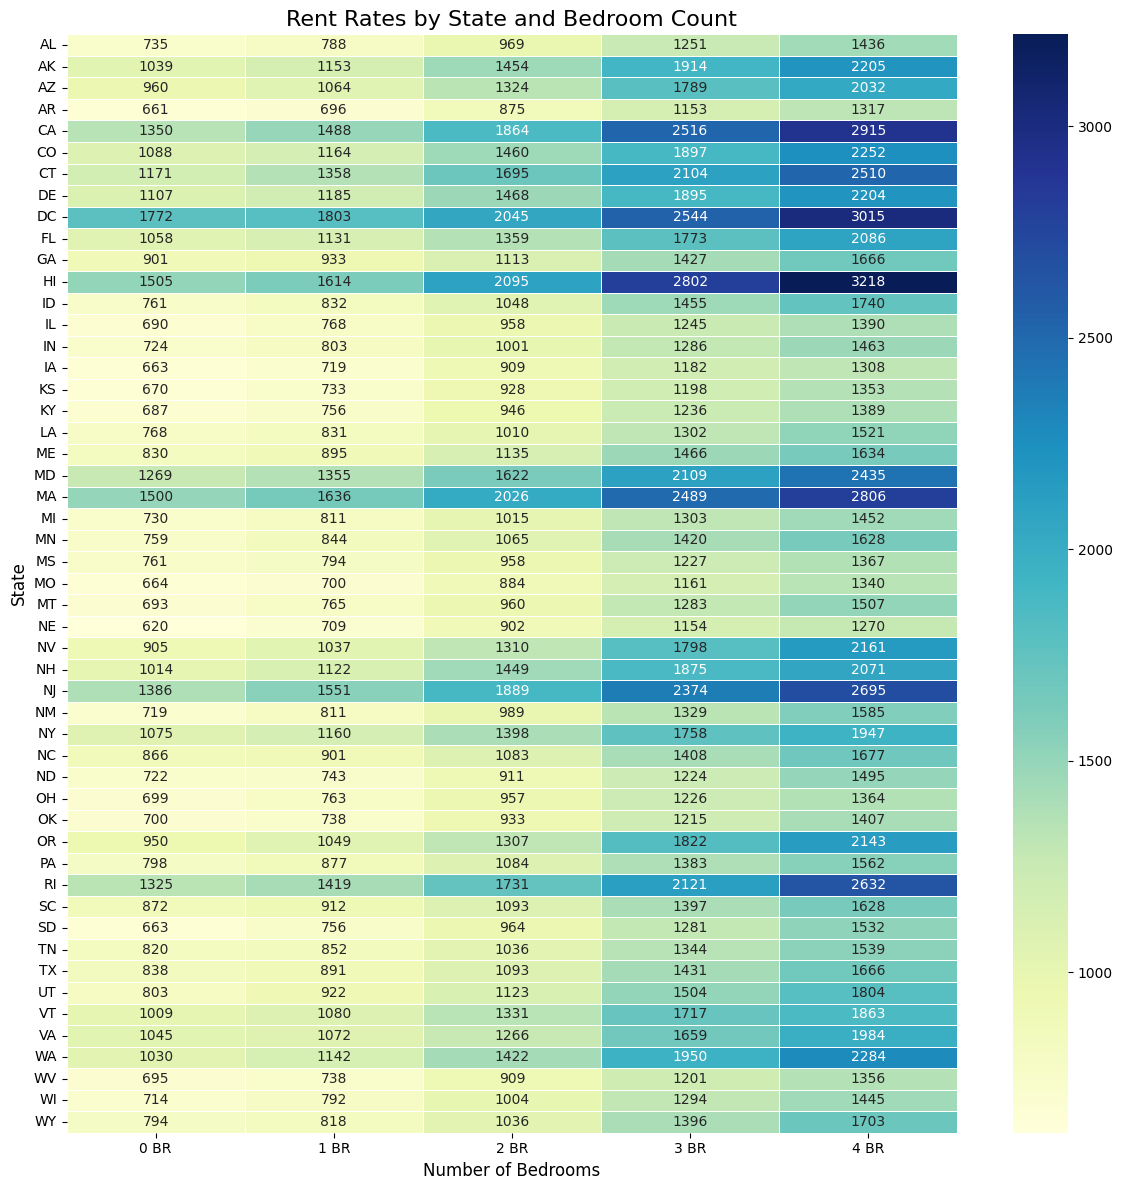

In [168]:
# Heat map of rent prices per state per bedroom
heatmap_data = rent_rates.set_index('State')

plt.figure(figsize=(12, 12))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Rent Rates by State and Bedroom Count", fontsize=16)
plt.xlabel("Number of Bedrooms", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

### Calculations assuming buying a house with a 20% downpayment mortgage

In [169]:
# Constants for calculation (taken from Assumptions section)
repair_cost_rate = 0.04
down_payment_rate = 0.20
mortgage_rate = 0.0631
loan_term_years = 30
monthly_interest_rate = mortgage_rate / 12
total_payments = loan_term_years * 12

# Filter tax rates by state and year (2024)
tax_rates_2024 = tax_rates[['State', '2024']]

# Function to calculate NOI for each row
def calculate_noi(row, bedroom_size):
    price = row[oct_2024_column]
    state = row['State']

    # Get tax rate and rent rate
    tax_rate = tax_rates.loc[tax_rates['State'] == state, '2024'].values
    rent_rate = rent_rates.loc[rent_rates['State'] == state, bedroom_size].values

    tax_rate = tax_rate[0]
    rent_rate = rent_rate[0]

    # Calculate loan amount and costs
    loan_amount = price * (1 - down_payment_rate)
    annual_taxes = price * tax_rate
    monthly_payment = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate)**total_payments) / ((1 + monthly_interest_rate)**total_payments - 1)
    annual_mortgage_payment = monthly_payment * 12
    annual_rent_income = rent_rate * 12

    # It's standard to set aside 10% of rent for ongoing property maintenance
    annual_maintenance_cost = annual_rent_income * 0.1

    # National average of $2100 per year for property insurance
    # TODO: make insurance more dynamic based on price and state
    annual_property_insurance = 2100
    
    noi = annual_rent_income - annual_taxes - annual_mortgage_payment - annual_maintenance_cost - annual_property_insurance
    return noi


# Apply the function to calculate Net Operating Income (NOI) for each dataset
price_data_1br['NOI'] = price_data_1br.apply(lambda row: calculate_noi(row, '1 BR'), axis=1)
price_data_2br['NOI'] = price_data_2br.apply(lambda row: calculate_noi(row, '2 BR'), axis=1)
price_data_3br['NOI'] = price_data_3br.apply(lambda row: calculate_noi(row, '3 BR'), axis=1)
price_data_4br['NOI'] = price_data_4br.apply(lambda row: calculate_noi(row, '4 BR'), axis=1)

/var/folders/p6/xr5l3xxs4092fm124qtzbfd00000gn/T/ipykernel_80551/2505068183.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data_1br['NOI'] = price_data_1br.apply(lambda row: calculate_noi(row, '1 BR'), axis=1)
/var/folders/p6/xr5l3xxs4092fm124qtzbfd00000gn/T/ipykernel_80551/2505068183.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data_2br['NOI'] = price_data_2br.apply(lambda row: calculate_noi(row, '2 BR'), axis=1)
/var/folders/p6/xr5l3xxs4092fm124qtzbfd00000gn/T/ipykernel_80551/2505068183.py:44: Perform

### Display Data

In [170]:
# Convert NOI to numeric and handle errors
price_data_1br['NOI'] = pd.to_numeric(price_data_1br['NOI'], errors='coerce')
price_data_2br['NOI'] = pd.to_numeric(price_data_2br['NOI'], errors='coerce')
price_data_3br['NOI'] = pd.to_numeric(price_data_3br['NOI'], errors='coerce')
price_data_4br['NOI'] = pd.to_numeric(price_data_4br['NOI'], errors='coerce')

# Drop rows with NaN in NOI
price_data_1br = price_data_1br.dropna(subset=['NOI'])
price_data_2br = price_data_2br.dropna(subset=['NOI'])
price_data_3br = price_data_3br.dropna(subset=['NOI'])
price_data_4br = price_data_4br.dropna(subset=['NOI'])

# Extract top 3 rows by NOI
top_3_noi_1br = price_data_1br.nlargest(3, 'NOI')
top_3_noi_2br = price_data_2br.nlargest(3, 'NOI')
top_3_noi_3br = price_data_3br.nlargest(3, 'NOI')
top_3_noi_4br = price_data_4br.nlargest(3, 'NOI')

# Add a function to calculate ROI
def calculate_roi(row):
    price = row[oct_2024_column]
    noi = row['NOI']
    
    # Calculate components of total investment
    down_payment = price * down_payment_rate
    repair_cost = price * repair_cost_rate
    total_investment = down_payment + repair_cost
    
    # Division by zero check
    if total_investment == 0:
        return None
    
    # Calculate ROI
    roi = (noi / total_investment) * 100
    row['TotalInvestment'] = total_investment  # Add Total Investment to the row
    return roi

# Apply the function to calculate ROI for each bedroom type
price_data_1br['ROI'] = price_data_1br.apply(calculate_roi, axis=1)
price_data_2br['ROI'] = price_data_2br.apply(calculate_roi, axis=1)
price_data_3br['ROI'] = price_data_3br.apply(calculate_roi, axis=1)
price_data_4br['ROI'] = price_data_4br.apply(calculate_roi, axis=1)

# Extract top 3 rows by ROI for each bedroom type
top_3_roi_1br = price_data_1br.nlargest(3, 'ROI')
top_3_roi_2br = price_data_2br.nlargest(3, 'ROI')
top_3_roi_3br = price_data_3br.nlargest(3, 'ROI')
top_3_roi_4br = price_data_4br.nlargest(3, 'ROI')

# Display the results
display("Top 3 ROI Rows for 1-Bedroom:")
display(top_3_roi_1br[['RegionName', 'State', oct_2024_column, 'NOI', 'ROI']])

display("\nTop 3 ROI Rows for 2-Bedroom:")
display(top_3_roi_2br[['RegionName', 'State', oct_2024_column, 'NOI', 'ROI']])

display("\nTop 3 ROI Rows for 3-Bedroom:")
display(top_3_roi_3br[['RegionName', 'State', oct_2024_column, 'NOI', 'ROI']])

display("\nTop 3 ROI Rows for 4-Bedroom:")
display(top_3_roi_4br[['RegionName', 'State', oct_2024_column, 'NOI', 'ROI']])


'Top 3 ROI Rows for 1-Bedroom:'

,RegionName,State,2024-10-31,NOI,ROI
1704,20705,MD,150767.436983,1952.541275,5.396118
1513,21212,MD,151595.576172,1894.419171,5.206889
546,20774,MD,157026.384493,1513.263430,4.015417


'\nTop 3 ROI Rows for 2-Bedroom:'

,RegionName,State,2024-10-31,NOI,ROI
9745,71241,LA,125120.861150,589.563906,1.963315
4975,71118,LA,126794.726339,479.617779,1.576097
5738,29341,SC,143681.160971,324.322015,0.940514


'\nTop 3 ROI Rows for 3-Bedroom:'

,RegionName,State,2024-10-31,NOI,ROI
20158,12035,NY,205859.620267,1079.679112,2.185306
20317,13615,NY,206204.140403,1053.225485,2.128201
5704,13820,NY,206289.220126,1046.692725,2.114129


'\nTop 3 ROI Rows for 4-Bedroom:'

,RegionName,State,2024-10-31,NOI,ROI
13346,13825,NY,235830.761442,819.575619,1.448029
9940,13340,NY,236403.024546,775.634980,1.367077
8555,13827,NY,236609.856769,759.753579,1.337915


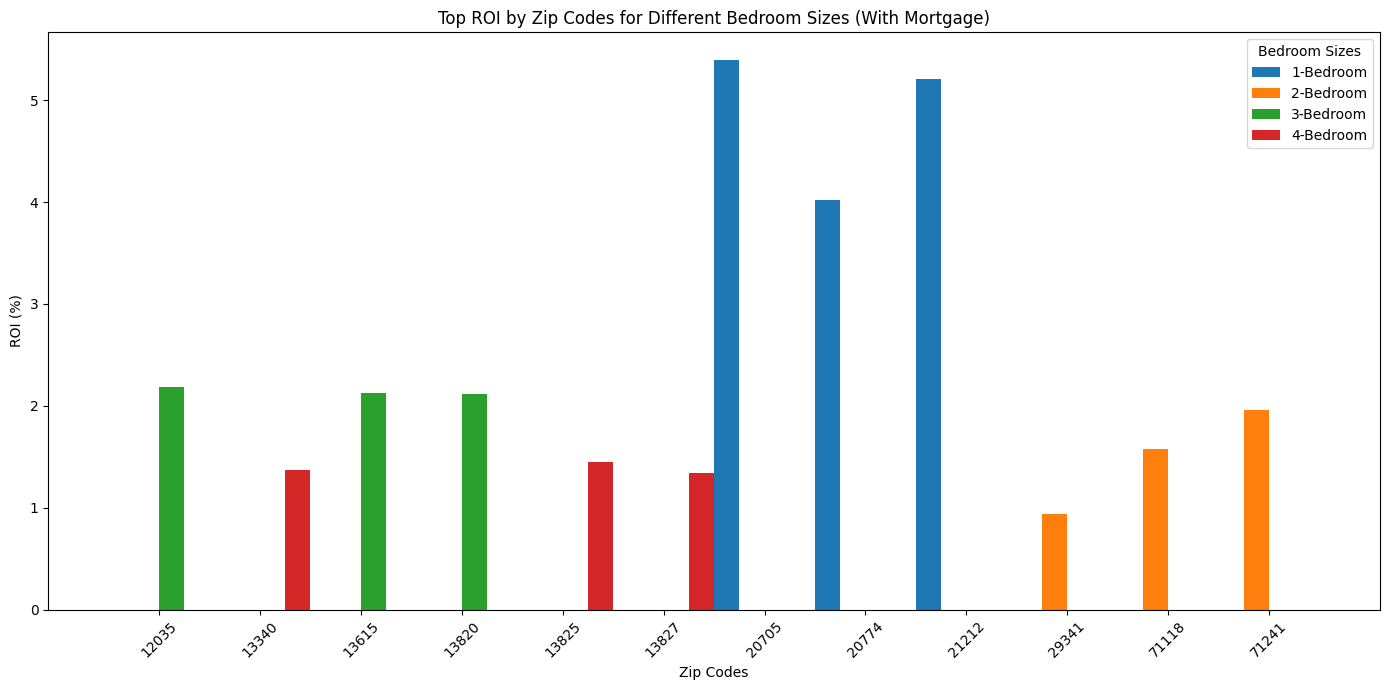

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from the top ROI data frames
top_3_roi_data = {
    "1-Bedroom": top_3_roi_1br[['RegionName', 'ROI']],
    "2-Bedroom": top_3_roi_2br[['RegionName', 'ROI']],
    "3-Bedroom": top_3_roi_3br[['RegionName', 'ROI']],
    "4-Bedroom": top_3_roi_4br[['RegionName', 'ROI']]
}

# Collect unique zip codes across all bedroom types
unique_zips = sorted(
    set(zip_code for data in top_3_roi_data.values() for zip_code in data['RegionName'])
)

# Initialize ROI values for all zip codes and bedroom sizes
zip_roi_data = {zip_code: [] for zip_code in unique_zips}

# Populate ROI data for each bedroom type
for bedroom, data in top_3_roi_data.items():
    for zip_code in unique_zips:
        # Append ROI if zip code exists in the data, otherwise append 0
        roi = data.loc[data['RegionName'] == zip_code, 'ROI']
        zip_roi_data[zip_code].append(roi.values[0] if not roi.empty else 0)

# Plot the bar graph
x = np.arange(len(unique_zips))  # X positions for groups
width = 0.25  # Bar width

plt.figure(figsize=(14, 7))

# Add bars for each bedroom type
for i, bedroom in enumerate(top_3_roi_data.keys()):
    plt.bar(
        x + i * width,
        [zip_roi_data[zip_code][i] for zip_code in unique_zips],
        width=width,
        label=bedroom
    )

# Add labels, title, and legend
plt.xlabel("Zip Codes")
plt.ylabel("ROI (%)")
plt.title("Top ROI by Zip Codes for Different Bedroom Sizes (With Mortgage)")
plt.xticks(x + width * 1.5, unique_zips, rotation=45)
plt.legend(title="Bedroom Sizes")
plt.tight_layout()

# Show the plot
plt.show()


### Calculations assuming no mortgage

In [172]:
# Function to calculate NOI for each row assuming no mortgage
def calculate_noi_no_mortgage(row, bedroom_size):
    price = row[oct_2024_column]
    state = row['State']

    # Get tax rate and rent rate
    tax_rate = tax_rates.loc[tax_rates['State'] == state, '2024'].values
    rent_rate = rent_rates.loc[rent_rates['State'] == state, bedroom_size].values

    tax_rate = tax_rate[0]
    rent_rate = rent_rate[0]

    # Calculate loan amount and costs
    annual_taxes = price * tax_rate
    annual_rent_income = rent_rate * 12
    
    # It's standard to set aside 10% of rent for ongoing property maintenance
    annual_maintenance_cost = annual_rent_income * 0.1

    # National average of $2100 per year for property insurance
    annual_property_insurance = 2100
    
    noi = annual_rent_income - annual_taxes - annual_maintenance_cost - annual_property_insurance
    return noi

# Add a function to calculate ROI
def calculate_roi_no_mortgage(row):
    price = row[oct_2024_column]
    noi = row['NOI_No_Mortgage']

    repair_cost = price * repair_cost_rate
    total_investment = price + repair_cost
    
    # Division by zero check
    if total_investment == 0:
        return None
    
    # Calculate ROI
    roi = (noi / total_investment) * 100
    row['TotalInvestment_No_Mortgage'] = total_investment
    return roi

# Apply the function to calculate Net Operating Income (NOI) for each dataset
price_data_1br['NOI_No_Mortgage'] = price_data_1br.apply(lambda row: calculate_noi_no_mortgage(row, '1 BR'), axis=1)
price_data_2br['NOI_No_Mortgage'] = price_data_2br.apply(lambda row: calculate_noi_no_mortgage(row, '2 BR'), axis=1)
price_data_3br['NOI_No_Mortgage'] = price_data_3br.apply(lambda row: calculate_noi_no_mortgage(row, '3 BR'), axis=1)
price_data_4br['NOI_No_Mortgage'] = price_data_4br.apply(lambda row: calculate_noi_no_mortgage(row, '4 BR'), axis=1)

# Apply the function to calculate ROI for each bedroom type
price_data_1br['ROI_No_Mortgage'] = price_data_1br.apply(calculate_roi_no_mortgage, axis=1)
price_data_2br['ROI_No_Mortgage'] = price_data_2br.apply(calculate_roi_no_mortgage, axis=1)
price_data_3br['ROI_No_Mortgage'] = price_data_3br.apply(calculate_roi_no_mortgage, axis=1)
price_data_4br['ROI_No_Mortgage'] = price_data_4br.apply(calculate_roi_no_mortgage, axis=1)

# Extract top 3 rows by ROI for each bedroom type
top_3_roi_1br = price_data_1br.nlargest(3, 'ROI_No_Mortgage')
top_3_roi_2br = price_data_2br.nlargest(3, 'ROI_No_Mortgage')
top_3_roi_3br = price_data_3br.nlargest(3, 'ROI_No_Mortgage')
top_3_roi_4br = price_data_4br.nlargest(3, 'ROI_No_Mortgage')

# Display the results
display("Top 3 ROI Rows for 1-Bedroom:")
display(top_3_roi_1br[['RegionName', 'State', oct_2024_column, 'NOI_No_Mortgage', 'ROI_No_Mortgage']])

display("\nTop 3 ROI Rows for 2-Bedroom:")
display(top_3_roi_2br[['RegionName', 'State', oct_2024_column, 'NOI_No_Mortgage', 'ROI_No_Mortgage']])

display("\nTop 3 ROI Rows for 3-Bedroom:")
display(top_3_roi_3br[['RegionName', 'State', oct_2024_column, 'NOI_No_Mortgage', 'ROI_No_Mortgage']])

display("\nTop 3 ROI Rows for 4-Bedroom:")
display(top_3_roi_4br[['RegionName', 'State', oct_2024_column, 'NOI_No_Mortgage', 'ROI_No_Mortgage']])

'Top 3 ROI Rows for 1-Bedroom:'

,RegionName,State,2024-10-31,NOI_No_Mortgage,ROI_No_Mortgage
1704,20705,MD,150767.436983,10920.788424,6.964871
1513,21212,MD,151595.576172,10911.927335,6.921203
546,20774,MD,157026.384493,10853.817686,6.646248


'\nTop 3 ROI Rows for 2-Bedroom:'

,RegionName,State,2024-10-31,NOI_No_Mortgage,ROI_No_Mortgage
9745,71241,LA,125120.861150,8032.250661,6.172686
4975,71118,LA,126794.726339,8021.872697,6.083328
5738,29341,SC,143681.160971,8871.049266,5.936655


'\nTop 3 ROI Rows for 3-Bedroom:'

,RegionName,State,2024-10-31,NOI_No_Mortgage,ROI_No_Mortgage
20158,12035,NY,205859.620267,13325.028569,6.223915
20317,13615,NY,206204.140403,13319.068371,6.210737
5704,13820,NY,206289.220126,13317.596492,6.207489


'\nTop 3 ROI Rows for 4-Bedroom:'

,RegionName,State,2024-10-31,NOI_No_Mortgage,ROI_No_Mortgage
13346,13825,NY,235830.761442,14847.727827,6.053774
9940,13340,NY,236403.024546,14837.827675,6.035093
8555,13827,NY,236609.856769,14834.249478,6.028363


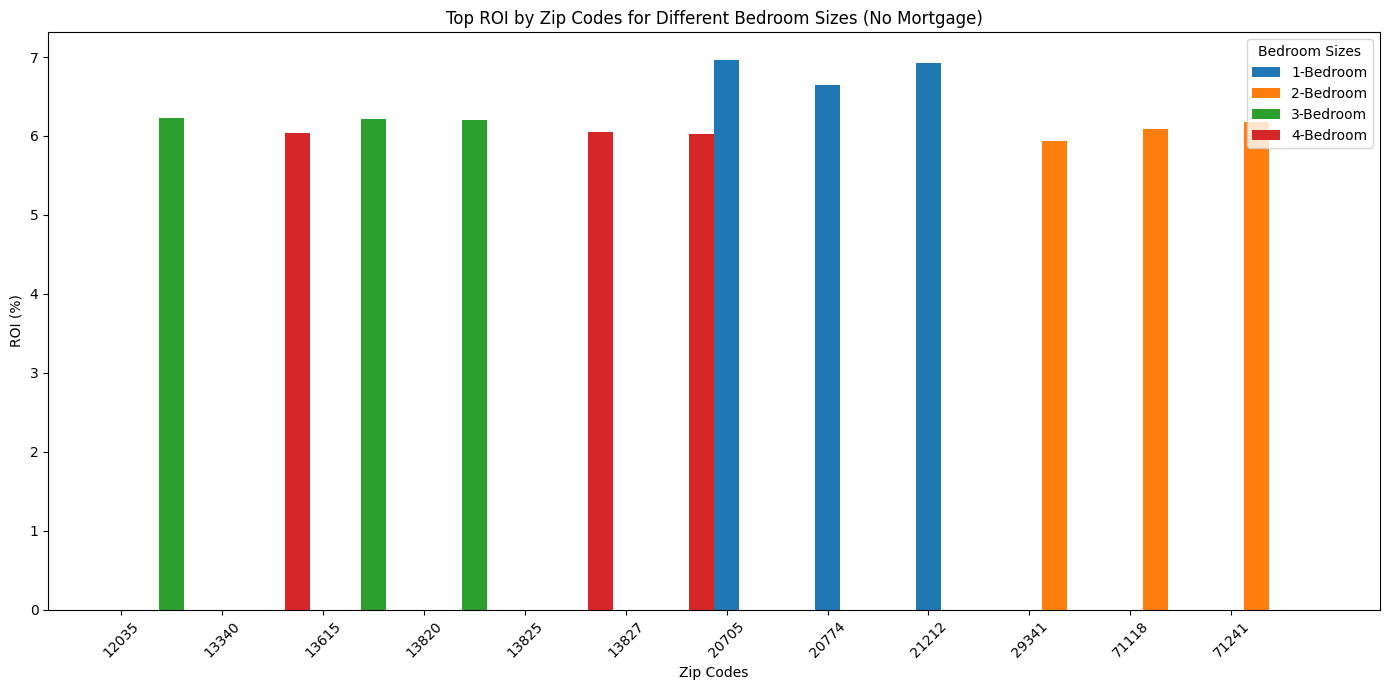

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from the top ROI data frames
top_3_roi_data = {
    "1-Bedroom": top_3_roi_1br[['RegionName', 'ROI_No_Mortgage']],
    "2-Bedroom": top_3_roi_2br[['RegionName', 'ROI_No_Mortgage']],
    "3-Bedroom": top_3_roi_3br[['RegionName', 'ROI_No_Mortgage']],
    "4-Bedroom": top_3_roi_4br[['RegionName', 'ROI_No_Mortgage']]
}

# Collect unique zip codes across all bedroom types
unique_zips = sorted(
    set(zip_code for data in top_3_roi_data.values() for zip_code in data['RegionName'])
)

# Initialize ROI values for all zip codes and bedroom sizes
zip_roi_data = {zip_code: [] for zip_code in unique_zips}

# Populate ROI data for each bedroom type
for bedroom, data in top_3_roi_data.items():
    for zip_code in unique_zips:
        # Append ROI if zip code exists in the data, otherwise append 0
        roi = data.loc[data['RegionName'] == zip_code, 'ROI_No_Mortgage']
        zip_roi_data[zip_code].append(roi.values[0] if not roi.empty else 0)

# Plot the bar graph
x = np.arange(len(unique_zips))  # X positions for groups
width = 0.25  # Bar width

plt.figure(figsize=(14, 7))

# Add bars for each bedroom type
for i, bedroom in enumerate(top_3_roi_data.keys()):
    plt.bar(
        x + i * width,
        [zip_roi_data[zip_code][i] for zip_code in unique_zips],
        width=width,
        label=bedroom
    )

# Add labels, title, and legend
plt.xlabel("Zip Codes")
plt.ylabel("ROI (%)")
plt.title("Top ROI by Zip Codes for Different Bedroom Sizes (No Mortgage)")
plt.xticks(x, unique_zips, rotation=45)
plt.legend(title="Bedroom Sizes")
plt.tight_layout()

# Show the plot
plt.show()


In [174]:
top_3_roi_1br.to_csv("top_3_roi_1br.csv", index=False)
top_3_roi_2br.to_csv("top_3_roi_2br.csv", index=False)
top_3_roi_3br.to_csv("top_3_roi_3br.csv", index=False)
top_3_roi_4br.to_csv("top_3_roi_4br.csv", index=False)

### Plot top 3 zip codes for 1, 2, 3, and 4 bedroom properties with Mortgage and without

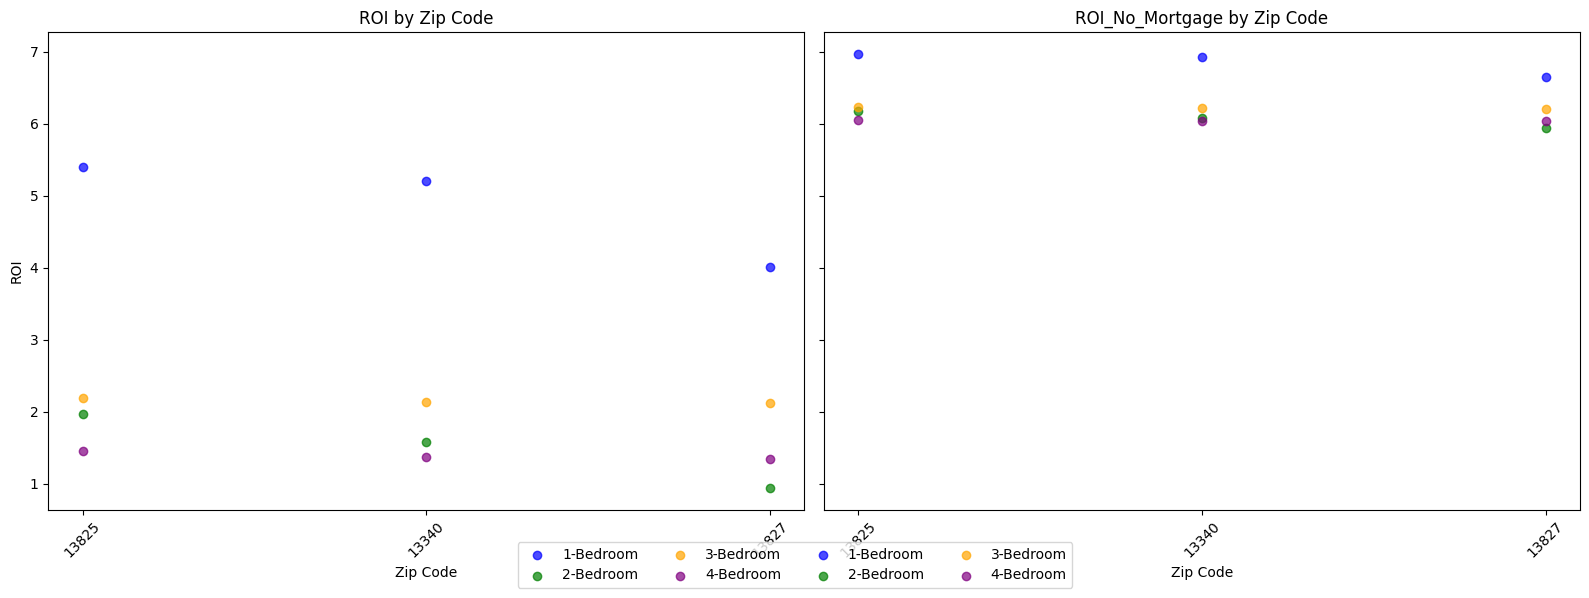

In [175]:
top_3_roi_data = {
    "1-Bedroom": top_3_roi_1br[['RegionName', 'ROI', 'ROI_No_Mortgage']],
    "2-Bedroom": top_3_roi_2br[['RegionName', 'ROI', 'ROI_No_Mortgage']],
    "3-Bedroom": top_3_roi_3br[['RegionName', 'ROI', 'ROI_No_Mortgage']],
    "4-Bedroom": top_3_roi_4br[['RegionName', 'ROI', 'ROI_No_Mortgage']]
}

colors = {
    "1-Bedroom": 'blue',
    "2-Bedroom": 'green',
    "3-Bedroom": 'orange',
    "4-Bedroom": 'purple'
}

# Create the scatter plots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Left plot for ROI
for bedroom_type, data in top_3_roi_data.items():
    # Map RegionName to indices to ensure categorical treatment
    x_indices = range(len(data['RegionName']))
    axs[0].scatter(x_indices, data['ROI'], label=bedroom_type, color=colors[bedroom_type], alpha=0.7)
axs[0].set_title('ROI by Zip Code')
axs[0].set_xlabel('Zip Code')
axs[0].set_ylabel('ROI')
axs[0].set_xticks(range(len(data['RegionName'])))  # Ensure ticks match indices
axs[0].set_xticklabels(data['RegionName'], rotation=45)  # Use zip codes as labels

# Right plot for ROI_No_Mortgage
for bedroom_type, data in top_3_roi_data.items():
    # Map RegionName to indices to ensure categorical treatment
    x_indices = range(len(data['RegionName']))
    axs[1].scatter(x_indices, data['ROI_No_Mortgage'], label=bedroom_type, color=colors[bedroom_type], alpha=0.7)
axs[1].set_title('ROI_No_Mortgage by Zip Code')
axs[1].set_xlabel('Zip Code')
axs[1].set_xticks(range(len(data['RegionName'])))  # Ensure ticks match indices
axs[1].set_xticklabels(data['RegionName'], rotation=45)  # Use zip codes as labels

# Add a legend to the right of the plots
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)

plt.tight_layout()
plt.show()


In [ ]:
# Write small report on the best Zip codes and house size